Load data for network from file

In [1]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from pprint import pprint
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline
sess = tf.InteractiveSession()
    

In [2]:
wine = np.genfromtxt("datasets/wine/wine_train_array.csv", delimiter=',')
wine_test = np.genfromtxt("datasets/wine/wine_test_array.csv", delimiter=',')

In [3]:
wine[0]

array([0.59210526, 0.17786561, 0.79569892, 0.25257732, 0.43478261,
       0.55862069, 0.68823529, 0.42      , 0.29746835, 0.28327645,
       0.49593496, 0.56981132, 0.48666128, 1.        , 0.        ,
       0.        ])

In [4]:
X = wine[:,:-3]
Y = wine[:,-3:]
X_t = wine_test[:,:-3]
Y_t = wine_test[:,-3:]


In [5]:
X[0]

array([0.59210526, 0.17786561, 0.79569892, 0.25257732, 0.43478261,
       0.55862069, 0.68823529, 0.42      , 0.29746835, 0.28327645,
       0.49593496, 0.56981132, 0.48666128])

In [6]:
Y[0]

array([1., 0., 0.])

In [7]:
#train_x,train_y,test_x,test_y = create_feature_sets_and_labels('Data/pos.txt','Data/neg.txt')
train_x = X
train_y = Y

test_x = X_t
test_y = Y_t



In [8]:
class TfAnn(object):
    
    def __init__(self):
        self.hidden=[]
        self.np_hidden=[]
        
        self.n_nodes=[]
        self.n_classes = 0
        self.n_hiden_layers = 0

    
    def init_empty(self,layers,n_classes,size):
        self.n_classes = n_classes
        self.n_hiden_layers = len(layers)
        for i in range(self.n_hiden_layers):
            self.hidden.append({'weights':[],'biases':[]})
            self.np_hidden.append({'weights':[],'biases':[]})
            self.n_nodes.append(layers[i])
        self.output_layer = {'weights':[],'biases':[]}
        self.np_output_layer={"weights":[],"biases":[]}

        for i in range(self.n_hiden_layers):
            self.hidden[i] = {'weights':tf.Variable(tf.random_normal([size, self.n_nodes[i]])),
                      'biases':tf.Variable(tf.random_normal([self.n_nodes[i]]))}
            
        self.output_layer = {'weights':tf.Variable(tf.random_normal([self.n_nodes[-1], self.n_classes])),
                        'biases':tf.Variable(tf.random_normal([self.n_classes]))}


    def init_json(self,tf_json):
        tf_data = json.loads(tf_json)
        self.n_classes = tf_data["n_classes"]
        self.n_hiden_layers = tf_data["n_hiden_layers"]
        self.hidden =tf_data["hidden"]
        self.output_layer =tf_data["output"]


    def create(self,data):
        # This is the heart of the ann where multiply the data by the wights to the layers 
        for i in range(self.n_hiden_layers):
            layer = tf.add(tf.matmul(data,self.hidden[i]['weights']), self.hidden[i]['biases'])
            layer= tf.nn.relu(layer)
        output =  tf.add(tf.matmul(layer,self.output_layer['weights']) , self.output_layer['biases'])
        return output
    
    def extract(self):
        for i in range(self.n_hiden_layers):
            self.np_hidden[i]["weights"] = neural_network_model.hidden[i]["weights"].eval().tolist()
            self.np_hidden[i]["biases"] = neural_network_model.hidden[i]["biases"].eval().tolist()
        self.np_output_layer["weights"] = neural_network_model.output_layer["weights"].eval().tolist()
        self.np_output_layer["biases"] = neural_network_model.output_layer["biases"].eval().tolist()
        return json.dumps({"n_classes":self.n_classes,"n_hiden_layers":self.n_hiden_layers ,"hidden":self.np_hidden,"output":self.np_output_layer}, ensure_ascii=False)
        
        

In [9]:
def train_neural_network_interactive(neural_network_model,x_data_train,y_data_train,x_data_test,y_data_test):
    x = tf.placeholder('float')
    y = tf.placeholder('float')
    prediction = neural_network_model.create(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    hm_epochs = 2500
    init = tf.initialize_all_variables()
    sess.run(init)
    losses=[]
    for epoch in range(hm_epochs):
            _, c = sess.run([optimizer, cost], feed_dict={x:x_data_train,
                                                          y:y_data_train})
            losses.append(c)
    cf = test_neural_network(neural_network_model,x_data_test,y_data_test)
    return cf,losses
   

In [10]:
def test_neural_network(neural_network_model,x_data_test,y_data_test):
    x = tf.placeholder('float')
    prediction = neural_network_model.create(x)    
    y_test_res=(sess.run(prediction,feed_dict={x:x_data_test}))       
    true_class=np.argmax(y_data_test,1)
    predicted_class=np.argmax(y_test_res,1)
    cm = confusion_matrix(predicted_class,true_class)
    cm = cm.astype('float')*10000 / cm.sum(axis=1)[:, np.newaxis]
    cm = np.nan_to_num(cm, copy=True)
    cm = cm.astype('int')
    return cm*0.01

In [11]:
from sklearn.model_selection import StratifiedKFold
train_index=[]
test_index=[]
splits =5
skf = StratifiedKFold(n_splits=splits,random_state=0,shuffle=True)
for train_idx, test_idx in skf.split(train_x,train_y[:,0]):               
    train_index.append(train_idx)
    test_index.append(test_idx)

In [12]:
import seaborn as sns
def plot_confusion_matrix(cm, classes, title,classifier_name):
    plt.rcParams.update({'font.size': 18})
    fig,ax= plt.subplots(figsize=(5,4))
    sns.set(font_scale=1.5)
    sns_plot = sns.heatmap(cm, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
array([[ 90.  ,   0.  ,  10.  ],
       [  7.69,  92.3 ,   0.  ],
       [  0.  ,   0.  , 100.  ]])


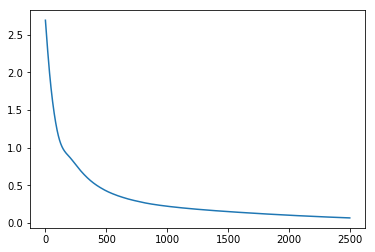

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 100.]])


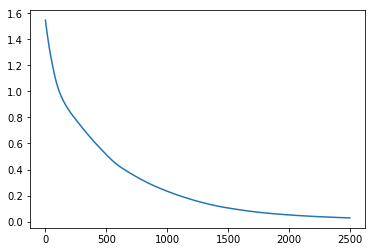

array([[90.  ,  0.  , 10.  ],
       [ 0.  , 91.66,  8.33],
       [ 0.  , 33.33, 66.66]])


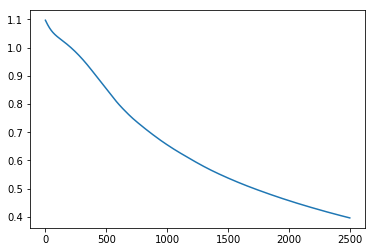

array([[ 90.,  10.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 100.]])


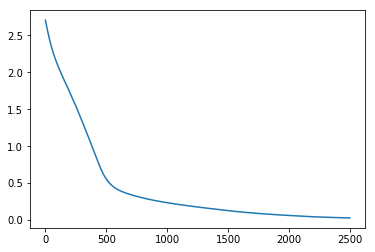

array([[ 90.,  10.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 100.]])


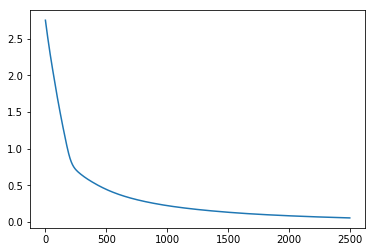

array([[92.   ,  4.   ,  4.   ],
       [ 1.538, 96.792,  1.666],
       [ 0.   ,  6.666, 93.332]])


In [13]:
av_cf = np.empty([3,3,0])
for fold in range(splits):
    neural_network_model = TfAnn()
    neural_network_model.init_empty([13,6],len(train_y[0]),len(train_x[0]))
    x_data_train = train_x[train_index[fold]]
    y_data_train = train_y[train_index[fold]] 
    x_data_test = train_x[test_index[fold]]
    y_data_test = train_y[test_index[fold]]
    cf,loss = train_neural_network_interactive(neural_network_model,x_data_train,y_data_train,x_data_test,y_data_test)
    av_cf = np.dstack([av_cf,cf])
    pprint( cf)
    #plot_confusion_matrix(cf,[1,2,3],"Cf matrix","wine")
    plt.plot(loss)
    plt.show()
pprint(av_cf.mean(axis=2))

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 100.]])


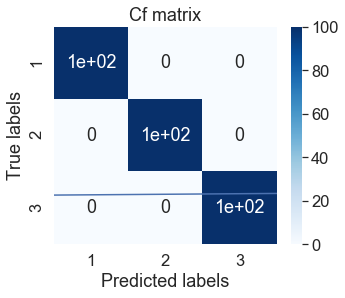

In [167]:
neural_network_model = TfAnn()
neural_network_model.init_empty([13,6],len(train_y[0]),len(train_x[0]))
x_data_train = train_x
y_data_train = train_y
x_data_test = train_x
y_data_test = train_y
cf,loss = train_neural_network_interactive(neural_network_model,x_data_train,y_data_train,x_data_test,y_data_test)
pprint(cf)
plot_confusion_matrix(cf,[1,2,3],"Cf matrix","wine")
plt.plot(loss)
plt.show()

In [168]:
tf_json = neural_network_model.extract()

In [169]:
pprint(tf_json)

('{"n_classes": 3, "n_hiden_layers": 2, "hidden": [{"weights": '
 '[[3.2011561393737793, -0.7531359791755676, -0.4829103648662567, '
 '-0.6212006211280823, -0.24564331769943237, 0.05392329767346382, '
 '0.6616443991661072, 0.8394348621368408, -0.2179415374994278, '
 '-1.0951902866363525, 1.266553282737732, 1.2120903730392456, '
 '-0.44938039779663086], [-1.5158650875091553, -0.24158717691898346, '
 '1.4661997556686401, 0.21096834540367126, 0.9112161993980408, '
 '1.514867901802063, -0.24224989116191864, 0.5869039297103882, '
 '-0.44910022616386414, 0.4643579125404358, -2.0254077911376953, '
 '0.7885514497756958, -1.4757707118988037], [-0.9478054642677307, '
 '-0.5695460438728333, -0.5223478674888611, -1.9654022455215454, '
 '0.3046714961528778, -0.8195757269859314, -2.161827802658081, '
 '-1.480160117149353, -0.17490501701831818, 0.8177843689918518, '
 '-1.1306862831115723, -1.915065884590149, -0.6283437609672546], '
 '[1.3348424434661865, -0.2063630074262619, -0.03783615306019783, '
 

In [170]:
neural_network_model = TfAnn()
neural_network_model.init_json(tf_json)
x_data_test = train_x
y_data_test = train_y
pprint(test_neural_network(neural_network_model,x_data_test,y_data_test))


array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 100.]])


array([[100. ,   0. ,   0. ],
       [  0. ,  87.5,  12.5],
       [  0. ,   0. , 100. ]])


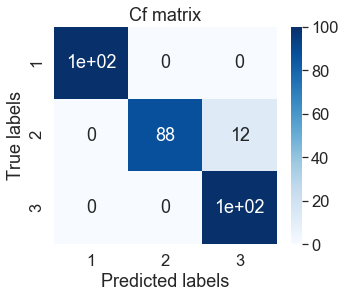

In [171]:
neural_network_model = TfAnn()
neural_network_model.init_json(tf_json)
x_data_test = train_x
y_data_test = train_y
cf = test_neural_network(neural_network_model,test_x,test_y)
pprint(test_neural_network(neural_network_model,test_x,test_y))
plot_confusion_matrix(cf,[1,2,3],"Cf matrix","wine")